# Работа с историческими данными пары BTC-USD

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use('seaborn-notebook')


## ARIMA  
Мы провели EDA (в предыдущем ноутбуке) и оказалось, что временной ряд наших данных ности НЕ стационарный характер, однако он неплохо приводится к стационарности с помощью логарифмирования (преобразования Бокса-Кокса), последующего дифференцирования и повтороного деффиринцирования, эти манипуляции над даннными позволяют нам стабилизировать дисперсию, избавится от трендов и перейти к предсказанию (держим в голове, что многократное диффернцирование дает нам "красивую" дисперсию, но "размывает" предсказанные значения). Посмотрим что нам сможет дать модель ARIMA.


In [16]:
# загрузим данные
data=pd.read_csv('bitcoin 2012-01-01_to_2021-03-31.csv')
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# удалим порпущенные, по онисанию в дни пропущенных значений не было торгов
# есть еще вариант заполнить пустые значения соседними...
# data['Volume_(BTC)'].fillna(data['Volume_(BTC)'].mean(),inplace=True)
# data['High'].fillna(method='ffill', inplace=True)
data.dropna(inplace=True)
print('Записей в нашем датасете после удаления NaN :', data.shape[0])

Записей в нашем датасете после удаления NaN : 3613769


In [18]:
# преобразуем Timestamp	в привычный/понятный и сделаем его индексом 
data.Timestamp = pd.to_datetime(data.Timestamp, unit='s')
data.index = data.Timestamp
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,,
2011-12-31 07:52:00,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
2011-12-31 15:50:00,2011-12-31 15:50:00,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
2011-12-31 16:59:00,2011-12-31 16:59:00,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
2011-12-31 17:00:00,2011-12-31 17:00:00,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
2012-01-01 04:16:00,2012-01-01 04:16:00,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000


In [19]:
# Дневные данные
data = data.resample('D').mean()
# Месячные данные
data_month = data.resample('M').mean()
# Квартальные данные 
data_Q = data.resample('Q-DEC').mean()
# Годовые данные
data_year = data.resample('A-DEC').mean()
# Квартальные данные 
data_Q = data.resample('Q-DEC').mean()

In [21]:
data.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
2012-01-01,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667
2012-01-02,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
2012-01-03,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500
2012-01-04,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159


In [30]:
# прологарифмируем наши данные
data_month_log=np.log(data_month)

Найдем количество необходимых дифференцирований (с помощью метода ndiffs модуля pmdarima).

In [32]:
from pmdarima.arima.utils import ndiffs
adftest = ndiffs(data_month_log['Weighted_Price'], test = 'adf')
kpsstest = ndiffs(data_month_log['Weighted_Price'], test = 'kpss')
print('ndiffs DF-test =', adftest)
print('ndiffs KPSS-test =', kpsstest)

ndiffs DF-test = 1
ndiffs KPSS-test = 1


__ARIMA.__

In [33]:
# продеффиринцируем наши отлогарифмированные данные и удалим пустые значения
data_month_log_diff=data_month_log.diff().dropna()

Для оценки гиперпараметров модели ARIMA посмотрим на автокорреляционную функцию (ACF) и частичную автокорреляционную функцию (PACF). Начальное приближение q выбирается как последний значимый несезонный лаг ACF (0 не считается), p выбирается аналогично опираясь на PACF. 

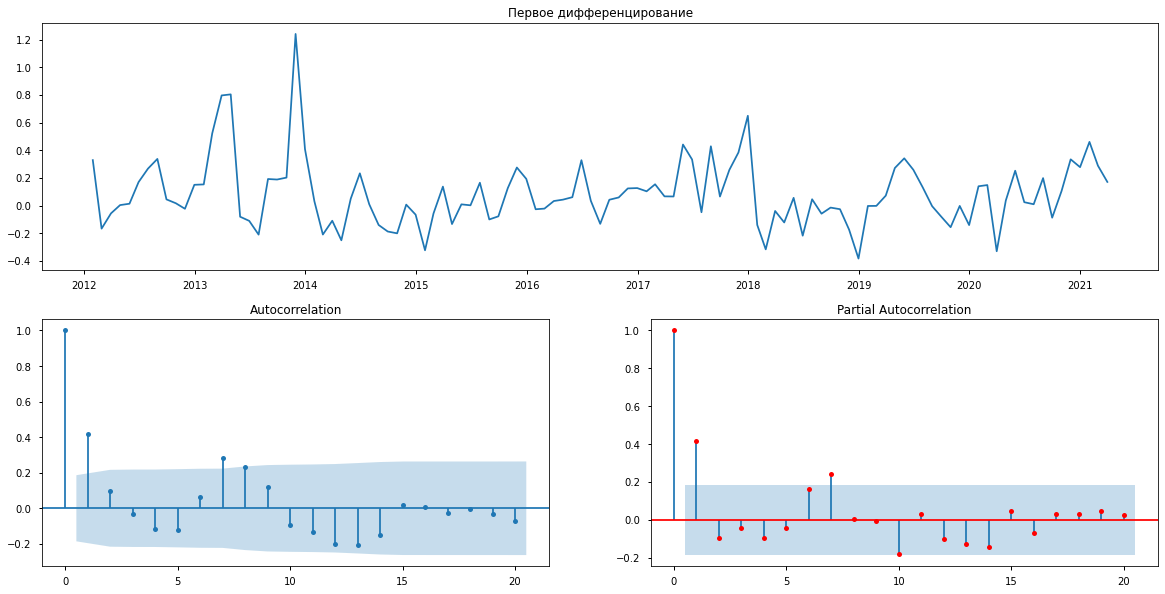

In [36]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
ax1.set_title('Первое дифференцирование')
ax2 = fig.add_subplot(2,2,3)
ax3 = fig.add_subplot(2,2,4)

ax1.plot(data_month_log_diff['Weighted_Price'])
plot_acf(data_month_log_diff['Weighted_Price'], lags=20, ax=ax2);
plot_pacf(data_month_log_diff['Weighted_Price'], lags=20, ax=ax3, color='r', method='ywm')
plt.show()

Примем p=1, q=1

In [39]:
from statsmodels.tsa.arima.model import ARIMA
p=1 
d=1 
q=1
arima = ARIMA(data_month_log['Weighted_Price'], order=(p,d,q)) #1,1,1
#arima = arima.fit(disp = 0 )
arima = arima.fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Weighted_Price   No. Observations:                  112
Model:                 ARIMA(1, 1, 1)   Log Likelihood                   8.569
Date:                Mon, 21 Feb 2022   AIC                            -11.137
Time:                        17:52:32   BIC                             -3.009
Sample:                    12-31-2011   HQIC                            -7.840
                         - 03-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3920      0.197      1.990      0.047       0.006       0.778
ma.L1          0.1184      0.250      0.473      0.636      -0.372       0.609
sigma2         0.0500      0.004     13.309      0.000       0.043       0.057
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):               121.34
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                             1.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

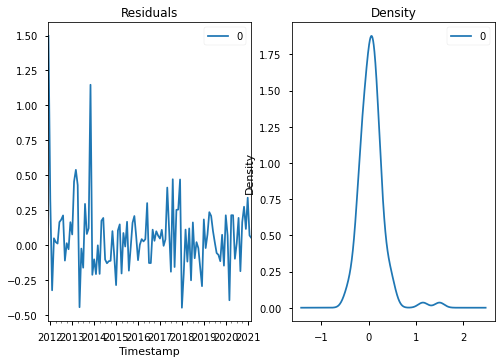

In [47]:
myresiduals = pd.DataFrame(arima.resid) 
fig, ax = plt.subplots(1,2) 
myresiduals.plot(title = "Residuals", ax = ax[0]) 
myresiduals.plot(kind = 'kde', title = 'Density', ax = ax[1]) 
plt.show() 

In [75]:
from pmdarima.arima import auto_arima
arima_model= auto_arima(data_month_log['Weighted_Price'], d=1, start_q=0,\
    max_p=12, max_d=12, max_q=12, start_P=0, D=1, start_Q=0, max_P=12, max_D=12,\
        max_Q=12, m=12, seasonal=True, error_action='warn', trace=True,\
            suppress_warnings=True, stepwise=True, random_state=20, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=69.848, Time=0.11 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=95.087, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=30.383, Time=0.50 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.16 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=68.710, Time=0.11 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=20.282, Time=1.04 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=17.500, Time=1.66 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=19.498, Time=3.64 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=19.498, Time=3.82 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=18.073, Time=1.48 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=21.499, Time=5.76 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=30.197, Time=1.18 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=19.317, Time=1.40 sec
 ARIMA(1,1,1)(3,1,0)[12]             : AIC=19.338, Time=2.47 sec
 ARIMA(0,1,1)(3,1,0)[12]             : AIC=18.718,

In [51]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  112
Model:             SARIMAX(1, 1, 0)x(3, 1, 0, 12)   Log Likelihood                  -3.750
Date:                            Mon, 21 Feb 2022   AIC                             17.500
Time:                                    19:54:53   BIC                             30.476
Sample:                                         0   HQIC                            22.750
                                            - 112                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4032      0.098      4.118      0.000       0.211       0.595
ar.S.L12      -0.9321      0.102     -9.103      0.000      -1.133      -0.731
ar.S.L24      -0.6381      0.141     -4.541      0.000      -0.914      -0.363
ar.S.L36      -0.3174      0.120     -2.639      0.008      -0.553      -0.082
sigma2         0.0555      0.008      6.731      0.000       0.039       0.072
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 9.76
Prob(Q):                              0.90   Prob(JB):                         0.01
Heteroskedasticity (H):               0.48   Skew:                             0.66
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [73]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(data_month_log.Weighted_Price,order=(1, 1, 0),
                                seasonal_order=(3, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
sarimax = mod.fit()
print(sarimax.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2485      0.139      1.786      0.074      -0.024       0.521
ar.S.L12      -0.8383      0.116     -7.204      0.000      -1.066      -0.610
ar.S.L24      -0.5766      0.139     -4.142      0.000      -0.849      -0.304
ar.S.L36      -0.3173      0.116     -2.742      0.006      -0.544      -0.090
sigma2         0.0422      0.007      5.622      0.000       0.027       0.057


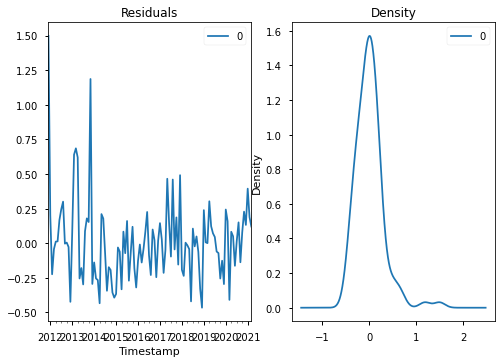

In [74]:
myresiduals = pd.DataFrame(sarimax.resid) 
fig, ax = plt.subplots(1,2) 
myresiduals.plot(title = "Residuals", ax = ax[0]) 
myresiduals.plot(kind = 'kde', title = 'Density', ax = ax[1]) 
plt.show() 